In [63]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

In [10]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [11]:
url = ("Data/Promedio_de_Apertura_Disney_2008-2018.csv"
)
datos = pd.read_csv(url, sep=";")

In [12]:
column_name=datos.columns.values
datos.head(4)


,Year,Trim,PromAp
0,2008,1,31.89
1,2008,2,32.49
2,2008,3,31.38
3,2008,4,26.06


In [13]:
# Tipo de cada columna
# ==============================================================================

datos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    44 non-null     int64  
 1   Trim    44 non-null     int64  
 2   PromAp  44 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.2 KB


In [14]:
# Dimensiones del dataset
# ==============================================================================
datos.shape

(44, 3)

In [15]:
# Número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

Year      0
Trim      0
PromAp    0
dtype: int64

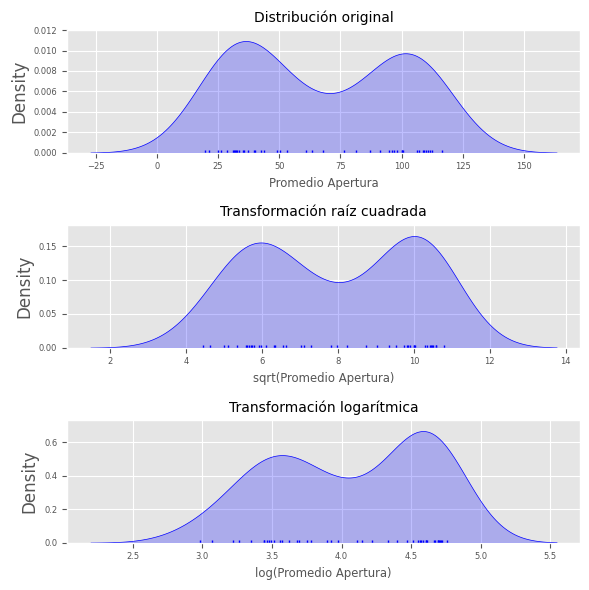

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    datos.PromAp,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    datos.PromAp,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Promedio Apertura', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(datos.PromAp),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(datos.PromAp),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Promedio Apertura)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(datos.PromAp),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(datos.PromAp),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Promedio Apertura)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [17]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(datos.PromAp, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

2024-06-17 20:09:21.041 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.026931)
2024-06-17 20:09:21.054 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.024941)
2024-06-17 20:09:21.077 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.027025)
2024-06-17 20:09:21.081 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.027983)
2024-06-17 20:09:21.103 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted logistic distribution with error=0.027224)
2024-06-17 20:09:21.178 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.027047)
2024-06-17 20:09:21.180 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.025016)
2024-06-17 20:09:21.247 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamm

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.024941,979.558224,983.126603,inf,0.168887,0.144604
chi2,0.025016,968.383765,973.736334,inf,0.172395,0.129734
exponpow,0.026104,1012.273735,1017.626304,inf,0.226472,0.018265
gamma,0.026868,960.576891,965.929460,inf,0.165268,0.161345
norm,0.026931,958.500655,962.069034,inf,0.166872,0.153743
powerlaw,0.027025,953.424843,958.777412,inf,0.238166,0.011125
beta,0.027047,1026.638867,1033.775625,inf,0.251615,0.006092
logistic,0.027224,968.437103,972.005482,inf,0.161333,0.181257
cauchy,0.027983,1022.551980,1026.120359,inf,0.195231,0.060562


In [18]:
# Variables numéricas
# ==============================================================================
datos.select_dtypes(include=['float64', 'int']).describe()


,Year,Trim,PromAp
count,44.000000,44.00000,44.000000
mean,2013.000000,2.50000,66.998182
std,3.198837,1.13096,33.316557
min,2008.000000,1.00000,19.770000
25%,2010.000000,1.75000,34.647500
50%,2013.000000,2.50000,62.205000
75%,2016.000000,3.25000,100.080000
max,2018.000000,4.00000,116.380000


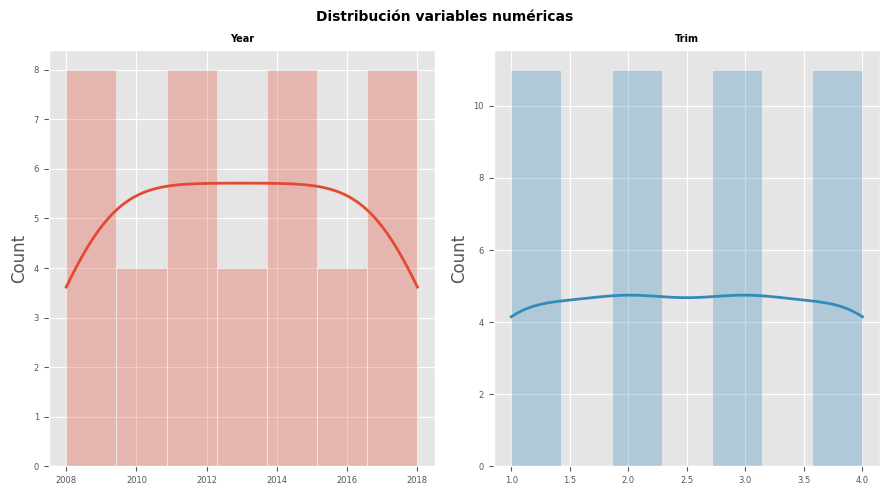

In [19]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('PromAp')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = datos,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

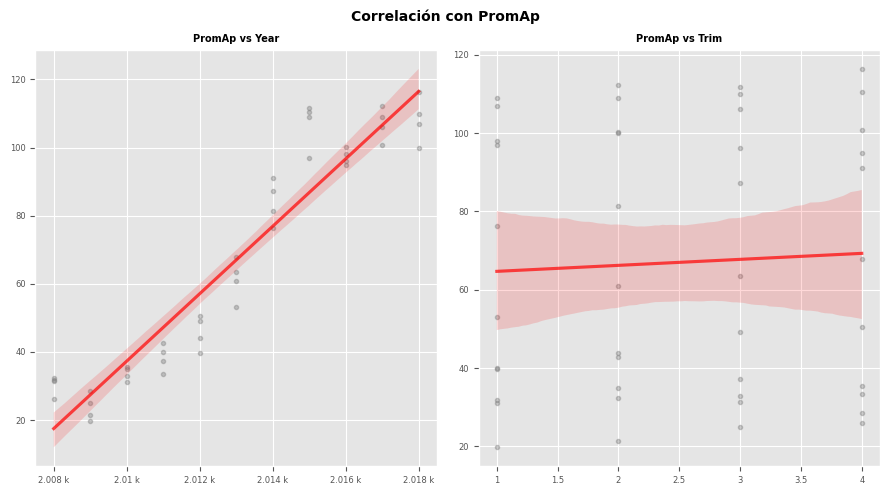

In [20]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('PromAp')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = datos[colum],
        y           = datos['PromAp'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"PromAp vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con PromAp', fontsize = 10, fontweight = "bold");


In [21]:
# Correlación entre columnas numéricas
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
2,Year,PromAp,9.501817e-01,9.501817e-01
6,PromAp,Year,9.501817e-01,9.501817e-01
5,Trim,PromAp,5.198039e-02,5.198039e-02
7,PromAp,Trim,5.198039e-02,5.198039e-02
1,Year,Trim,-8.244413e-15,8.244413e-15
3,Trim,Year,-8.244413e-15,8.244413e-15


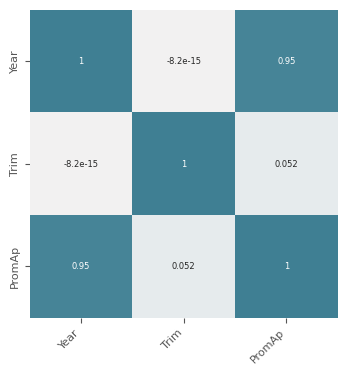

In [22]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [23]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('PromAp', axis = 'columns'),
                                        datos['PromAp'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [24]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count     35.000000
mean      68.804857
std       33.061704
min       21.500000
25%       35.290000
50%       67.960000
75%       99.025000
max      116.380000
Name: PromAp, dtype: float64


In [25]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count      9.000000
mean      59.972222
std       35.366981
min       19.770000
25%       32.870000
50%       43.970000
75%      100.260000
max      108.950000
Name: PromAp, dtype: float64


In [26]:
# Selección de las variables por tipo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


In [27]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [28]:
preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

X_train_prep.head(3)

,Year,Trim
34,0.905246,0.257343
25,0.283999,-0.643356
1,-1.579743,-0.643356


In [29]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(), ['Year', 'Trim']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 [])],
                  verbose_feature_names_out=False)

In [30]:
set_config(display='text')


In [31]:
# Selección de las variables por tipo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [32]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)
X_train_prep.head(3)

,Year,Trim
34,0.905246,0.257343
25,0.283999,-0.643356
1,-1.579743,-0.643356


In [33]:
from sklearn.linear_model import Ridge

# Preprocedado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

# Pipeline
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)

In [34]:
# Validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [ -8.90227399  -6.64476345 -12.47029546 -14.60481885  -9.41548581]
Média métricas de validación cruzada: -10.407527510259275


In [35]:
# Validación cruzada repetida
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
            )

print(f"Métricas de validación cruzada: {cv_scores}")
print("")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas de validación cruzada: [ -9.77589241  -9.60728679  -7.38065232  -9.1154599  -16.52577632
 -11.06837706 -10.75525309  -7.66417159  -6.45612615 -14.66861945
 -11.97190993  -7.31328534  -7.55320262 -14.84285519 -10.88020366
 -12.2233867   -9.35111738 -10.70248448  -8.45060301 -15.05399001
 -12.33750023 -10.71880597  -8.5254396  -12.07571579  -8.21970072]

Média métricas de validación cruzada: -10.529512628506936


In [36]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.015687,0.003001,0.858997,0.898280,-11.595017,-10.415978
1,0.008518,0.005522,0.924300,0.893582,-9.099435,-10.545370
2,0.006520,0.005979,0.776450,0.941047,-14.992698,-7.837851
3,0.008524,0.007499,0.839232,0.915101,-11.249101,-9.444412
4,0.010098,0.003564,0.948055,0.869589,-7.457693,-11.457167
5,0.010528,0.002999,0.850022,0.925318,-12.414237,-8.852123
6,0.008507,0.003006,0.876331,0.910893,-10.503922,-10.010341
7,0.008544,0.003981,0.896634,0.895603,-11.141835,-10.052763
8,0.004978,0.005538,0.888932,0.913712,-10.696840,-9.636237
9,0.006512,0.003325,0.917918,0.884739,-10.531914,-10.245326


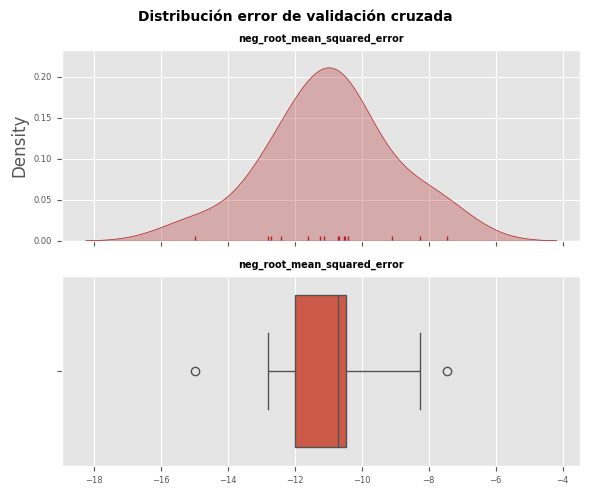

In [37]:
# Distribución del error de validación cruzada
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.kdeplot(
    cv_scores['test_neg_root_mean_squared_error'],
    fill    = True,
    alpha   = 0.3,
    color   = "firebrick",
    ax      = axes[0]
)
sns.rugplot(
    cv_scores['test_neg_root_mean_squared_error'],
    color   = "firebrick",
    ax      = axes[0]
)
axes[0].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[0].tick_params(labelsize = 6)
axes[0].set_xlabel("")
    
sns.boxplot(
    x  = cv_scores['test_neg_root_mean_squared_error'],
    ax = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[1].tick_params(labelsize = 6)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 10,
             fontweight = "bold");

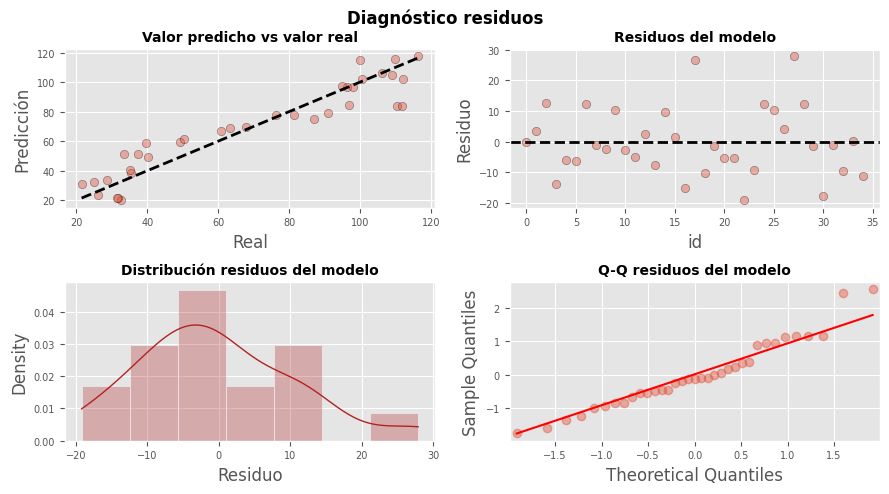

In [38]:
# Diagnóstico errores (residuos) de las predicciones de validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_prediccones = cross_val_predict(
                    estimator = pipe,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                 )

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

axes[0, 0].scatter(y_train, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    'k--', color = 'black', lw=2
)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), y_train - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [39]:
# Validación cruzada repetida paralelizada (multicore)
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 # todos los cores disponibles
            )

print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Média métricas de validación cruzada: -10.187306567358368


In [40]:
predicciones = pipe.predict(X_test)

In [41]:
# Se crea un dataframe con las predicciones y el valor real
df_predicciones = pd.DataFrame({'PromAp' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

,PromAp,prediccion
29,108.95,86.309539
17,43.97,58.199337
33,100.26,95.679606
40,106.92,113.814514
8,31.17,38.853976


In [42]:
df_predicciones=df_predicciones.sort_index()
df_predicciones.to_csv('outtest.csv')

In [43]:
predicciones = pipe.predict(X_train)

In [44]:
df_predicciones = pd.DataFrame({'PromAp' : y_train, 'prediccion' : predicciones})
df_predicciones.head()

,PromAp,prediccion
34,96.21,96.284832
25,81.34,76.939471
1,32.49,20.719068
14,37.32,49.434496
42,109.88,115.024967


In [45]:
df_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 34 to 19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PromAp      35 non-null     float64
 1   prediccion  35 non-null     float64
dtypes: float64(2)
memory usage: 840.0 bytes


In [46]:
df_predicciones=df_predicciones.sort_index()
df_predicciones.to_csv('outtrain.csv')

In [47]:
url = ("Data/añosapredecir.csv"
)
pre = pd.read_csv(url, sep=";")

In [48]:
predicciones2 = pipe.predict(pre)

In [49]:
df_prediccionesf = pd.DataFrame({'prediccion' : predicciones2})
orig=pd.DataFrame(pre)
out=pd.concat([orig,df_prediccionesf],axis=1)
out.head()


,Year,Trim,prediccion
0,2019,1,123.184582
1,2019,2,123.789808
2,2019,3,124.395034
3,2019,4,125.000260
4,2020,1,132.554649


In [50]:
out.to_csv('prediccion.csv')

In [53]:
#regresión, esto lo hago porque el de excel me dio raro
x=datos[['Year','Trim']]
y=datos['PromAp']

In [54]:
X_trainr, X_testr, y_trainr, y_testr = train_test_split(x, y, test_size=0.2, random_state=42)


In [59]:
modelo = LinearRegression()


In [60]:
modelo.fit(X_trainr, y_trainr)
y_pred = modelo.predict(X_testr)


In [65]:
mse = mean_squared_error(y_testr, y_pred)
r2 = r2_score(y_testr, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 27.692269612707165
R^2: 0.9756302145685247


In [70]:
regresion=modelo.predict(pre)

In [71]:
regresiondf=pd.DataFrame({'y hat' :regresion })

In [72]:
out2=pd.concat([orig,regresiondf],axis=1)
out2.head()


,Year,Trim,y hat
0,2019,1,124.056674
1,2019,2,125.157307
2,2019,3,126.257940
3,2019,4,127.358573
4,2020,1,133.806642


In [73]:
out2.to_csv('regresion.csv')

In [75]:
# Coeficientes
coeficientes = modelo.coef_
# Intercepto
intercepto = modelo.intercept_
print(coeficientes)
print(intercepto)


[9.74996733 1.10063297]
-19562.228006850088


In [86]:
regresionor=modelo.predict(x)
regresiondfor=pd.DataFrame({'y hat' :regresionor })
out3=pd.concat([x,regresiondfor],axis=1)
print(out3)

    Year  Trim       y hat
0   2008     1   16.807034
1   2008     2   17.907667
2   2008     3   19.008300
3   2008     4   20.108933
4   2009     1   26.557001
5   2009     2   27.657634
6   2009     3   28.758267
7   2009     4   29.858900
8   2010     1   36.306968
9   2010     2   37.407601
10  2010     3   38.508234
11  2010     4   39.608867
12  2011     1   46.056936
13  2011     2   47.157569
14  2011     3   48.258202
15  2011     4   49.358835
16  2012     1   55.806903
17  2012     2   56.907536
18  2012     3   58.008169
19  2012     4   59.108802
20  2013     1   65.556870
21  2013     2   66.657503
22  2013     3   67.758136
23  2013     4   68.858769
24  2014     1   75.306838
25  2014     2   76.407471
26  2014     3   77.508104
27  2014     4   78.608737
28  2015     1   85.056805
29  2015     2   86.157438
30  2015     3   87.258071
31  2015     4   88.358704
32  2016     1   94.806772
33  2016     2   95.907405
34  2016     3   97.008038
35  2016     4   98.108671
3

In [87]:
out3.to_csv('regresion2.csv')

In [88]:
print(f'{coeficientes[0]}X+{coeficientes[1]}x^2+{intercepto}')

9.749967334432458X+1.1006329724125634x^2+-19562.228006850088
